### What is BPNet?
Author: Jacob Schreiber \<jmschreiber91@gmail.com\>


#### Introduction

BPNet is a deep learning model trained to predict readouts from genomics experiments using nucleotide sequence [[paper]](https://www.nature.com/articles/s41588-021-00782-6). BPNet's innovation over other models of the time is that it makes predictions at basepair resolution (hence, the name) and decomposes the prediction task into that of making predictions for the total log counts in a region (the strength of the signal) and a probability distribution over the exact positions (the shape of the signal). It turns out that learning how to predict the shape of the signal resulted in models that achieved state-of-the-art accuracy because the exact positioning of reads in the profile contains quite a bit of information about the more subtle aspects of the cis-regulatory code. BPNet models were original introduced in the context of making predictions for transcription factor (TF) binding as measured by ChIP-nexus experiments but can, in principle, be trained for readouts of any sequencing-based experiment, although performance will vary. When the readouts are stranded, such as for TF binding or transcription initiation, BPNet makes predictions for both strands, though the signal being stranded is not a requirement for using BPNet.

The architecture of a BPNet model consists of an initial convolutional layer that is quite wide compared to the expected size of most motifs, followed by eight dilated residual convolutions that aggregate information across the input sequence, followed by outputs for the profile and counts predictions. The profile prediction proceeds by applying another wide convolution to the output of the last dilated residual convolution. The count prediction proceeds by averaging the representations across all positions and then using a single linear layer to predict a single value per example. As a final detail: a control track can be passed into the model by concatenating the per-position mapped counts to the feature representations before applying the last convolution or linear layers.

<img src="img/bpnet-schematic.png">

An important conceptual note is that BPNet is usually trained on the readouts from one experiment at a time, in contrast to large models such as Enformer, Borzoi, or AlphaGenome, which are trained on readouts from thousands of experiments simultaneously. Although training on a single experiment may yield lower predictive accuracy in some settings, limiting the focus of the model in this manner provides two important benefits. First, these models can be trained extremely quickly, allowing the pipeline from experimental data to machine learning analysis results to be quite fast. Second, because the model only ever sees data from one experiment, it cannot learn spurious correlations *between* tasks. This does not mean the BPNet models cannot learn spurious correlations of any sort, just that the model cannot connect TF binding sites learned for one task to all other tasks simply because machine learning models have a had time *not* connecting features to outputs once they have been identified.

#### Using bpnet-lite

##### Loading and Wrapping Models

Now that we conceptually understand what a BPNet model is, let's quickly take a look at some of the things you can do with bpnet-lite. We will talk much more about each of these topics in other tutorials, so please take a look at those if you want to know more about any of these topics.

First, we can load trained models easily! Here, we are loading a model that has been trained with bpnet-lite (see the BPNet pipeline tutorial for the exact details on how we trained this model). Note that we can also load models that have trained using the official BPNet repository, even though it is implemented in TensorFlow. See the tutorial for more details on how to do that.

In [1]:
import torch

model = torch.load("quick-jun.torch", weights_only=False)
model

BPNet(
  (iconv): Conv1d(4, 64, kernel_size=(21,), stride=(1,), padding=(10,))
  (irelu): ReLU()
  (rconvs): ModuleList(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
    (1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
    (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
    (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
    (4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
    (5): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
    (6): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
    (7): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(256,), dilation=(256,))
  )
  (rrelus): ModuleList(
    (0-7): 8 x ReLU()
  )
  (fconv): Conv1d(66, 2, kernel_size=(75,), stride=(1,), padding=(37,))
  (linear): Linear(in_features=65, out_features=1, bias=True)
)

You can see that the trained BPNet model from bpnet-lite is just a PyTorch module with no complicated wrappers or functions or I/O. This minimalism makes it easy to use these models in your personal development environments. Specifically, you can use these models in the same manner you can use any other PyTorch package and so they plug into any other package that expect PyTorch modules. For example, if you use PyTorch Lightning to train your models, you can easily just pass in these BPNet models without modification. Alternatively, if you use tangermeme to use your genomics models after trained, you can pass these models directly into those functions as we will see below.

To begin, we can use these BPNet models to make predictions for the profile and log counts of any sequence. However, because BPNet is trained using a control track as input to factorize out the influence of mapping bias, we need to pass in a control track here. Usually, an actual control track is used when training and evaluating the models on experimental data because the artifacts are observed in the experimental data and an all-zeroes control track is used at inference time to factorize out the influence of mapping artifacts that are not biologically interesting. This means that, for most downstream applications of BPNet, we want to pass in an all-zeroes track.

In [2]:
from tangermeme.predict import predict
from tangermeme.utils import random_one_hot

X = random_one_hot((1, 4, 2114), random_state=0)
X_ctl = torch.zeros((1, 2, 2114))

predict(model, X, args=(X_ctl,))

[tensor([[[-0.0901, -0.5976, -0.3234,  ...,  1.4522,  1.0508,  1.1012],
          [-0.3575, -0.5376, -1.4749,  ..., -0.2960, -0.4365, -0.2700]]]),
 tensor([[0.5266]])]

The output from these models is a tuple of two tensors with the first being the profile predictions and the second being the log count predictions. The profile predictions are broken down into predictions from each of the two strands and are in logit space, meaning that they have not been normalized to sum to 1 (or logsumexp to 0, since they're in log space). When you use these profile predictions, you will need to softmax them yourself if you need that property.

Passing in an all-zeroes control track can be annoying, so we have added in `ControlWrapper` which is a wrapper module that automatically generates an all-zeroes control track based on the dimensions of your input. To the user, it looks and operates exactly the same as the original model but now you do not need to pass in a control track to use it.

In [3]:
from bpnetlite.bpnet import ControlWrapper

model = torch.load("quick-jun.torch", weights_only=False)
model = ControlWrapper(model)
model

ControlWrapper(
  (model): BPNet(
    (iconv): Conv1d(4, 64, kernel_size=(21,), stride=(1,), padding=(10,))
    (irelu): ReLU()
    (rconvs): ModuleList(
      (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
      (1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
      (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
      (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
      (4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
      (5): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
      (6): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
      (7): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(256,), dilation=(256,))
    )
    (rrelus): ModuleList(
      (0-7): 8 x ReLU()
    )
    (fconv): Conv1d(66, 2, kernel_size=(75,), stride=(1,), padding=(37,))
    (lin

Note that this wrapped model can still be used in all downstream packages just as easily as the original model. It can also be saved to and loaded from disk without hassle. Personally, I do not usually save them because I want my code to be explicit about how base models are modified or wrapped to do analyses, but that is a matter of personal taste.

In [4]:
predict(model, X)

[tensor([[[-0.0901, -0.5976, -0.3234,  ...,  1.4522,  1.0508,  1.1012],
          [-0.3575, -0.5376, -1.4749,  ..., -0.2960, -0.4365, -0.2700]]]),
 tensor([[0.5266]])]

Once again, we get the profile and counts output and the values are the exact same as before. The only difference is we now do not need to pass in the optional arguments.

##### Inspecting Loci

Now that we know how to use the BPNet models, we can use them to take a look at a real JUN peak to get a sense for the kinds of insights BPNet can add to your work and how to use bpnet-lite to achieve those. Let's load up the peak set corresponding to the JUN experiment that this model was trained on. Note that the tangermeme function here can operate on BED files that are hosted remotely, so we do not even need to download and permanently store them.

In [5]:
from tangermeme.io import extract_loci

X = extract_loci(
    "https://www.encodeproject.org/files/ENCFF331IUK/@@download/ENCFF331IUK.bed.gz", 
    "../../../../common/hg38.fa", 
    verbose=True)

X.shape

Loading Loci: 100%|████████████████████████████████████████████████████████████| 18218/18218 [00:00<00:00, 59916.98it/s]


torch.Size([18214, 4, 2114])

Despite loading the regions remotely it only takes roughly ~1s to load and one-hot encode the ~18k peaks in preparation for our later usage.

In the same way that we made predictions for a single randomly generated region before, we can make predictions for the entire set of peaks using the same function. Internally, `predict` handles the batching of data, conversion to a uniform datatype, and moving batches of data (and the model) to the correct device.

In [6]:
profiles, counts = predict(model, X, verbose=True)
profiles = torch.softmax(profiles, dim=-1)

idx = counts.argmax()

profiles.shape, counts.shape

100%|████████████████████████████████████████████████████████████████████████████████| 570/570 [00:00<00:00, 621.18it/s]


(torch.Size([18214, 2, 1000]), torch.Size([18214, 1]))

Just like before, we are getting profile predictions at basepair resolution across both strands and log count predictions. Note that the profile predictions are the logits, which are the raw predicted values before a softmax normalization. This means that they do not sum (or log-sum-exp) to any particular value. These values can be more useful in a variety of settings than the raw predictions, but if you want predicted probabilities all you need to do is softmax across the last dimension.

Let's take a look at the region with the strongest predicted binding.

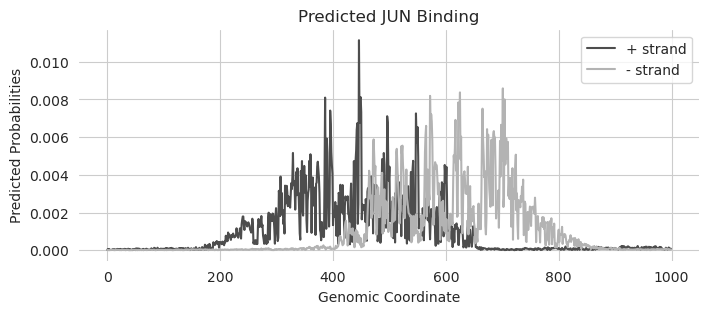

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set_style('whitegrid')

plt.figure(figsize=(8, 3))
plt.plot(profiles[idx][0], label='+ strand', c='0.3')
plt.plot(profiles[idx][1], label='- strand', c='0.7')
plt.title("Predicted JUN Binding")
plt.xlabel("Genomic Coordinate")
plt.ylabel("Predicted Probabilities")
plt.legend()
seaborn.despine(bottom=True, left=True)
plt.show()

This pattern is what you would expect for most TFs, with a peak for the positive strand coming first and a peak for the negative strand coming after. This is because BPNet is trained to predict only the read starts and not the entire length of the fragment. This choice was made because the length of the fragment is based on non-biological factors and the reads may even terminate before seeing the relevant motif. Another relevant issue is that if the entire length of the fragment were used, the pileup at any particular position would depend strongly on the length of any particular fragment, necessitating that each fragment be normalized by length.

Looking closer at the predictions, one can see something more interesting than most readouts: a cyclic pattern of spikes in both the positive and negative strands. Is this just noise in the predictions, or is there something more interesting happening here? 

We can use feature attribution methods such as DeepLIFT/SHAP to explore the sequence drivers of these predictions. However, these methods work best when they are explaining a single value as the output instead of an entire profile and so it may be initially easier to focus on explaining the log count predictions.

As a convenience, bpnet-lite provides a wrapper that will take the pair of outputs from a BPNet model and wrap them to only return the first one. This can be stacked with the control wrapper to yield a model that only takes in nucleotide sequence and only outputs log counts.

In [8]:
from bpnetlite.bpnet import CountWrapper

model = torch.load("quick-jun.torch", weights_only=False)
model = ControlWrapper(model)
count_model = CountWrapper(model)

predict(count_model, X, verbose=True), counts

100%|████████████████████████████████████████████████████████████████████████████████| 570/570 [00:00<00:00, 694.72it/s]


(tensor([[0.8294],
         [0.6294],
         [0.8181],
         ...,
         [1.7862],
         [1.7810],
         [2.4474]]),
 tensor([[0.8294],
         [0.6294],
         [0.8181],
         ...,
         [1.7862],
         [1.7810],
         [2.4474]]))

As an aside, there also exists a wrapper for the profiles. This does more than just pull out the profile predictions, though. It also transforms them in a manner described in the original BPNet paper by taking the dot product between the predicted logits and the softmaxed logits to return a single value per example that is solely based on the profile.

In [9]:
from bpnetlite.bpnet import ProfileWrapper

profile_model = ProfileWrapper(model)

predict(profile_model, X, verbose=True)

100%|████████████████████████████████████████████████████████████████████████████████| 570/570 [00:00<00:00, 673.61it/s]


tensor([[1.3220],
        [1.9733],
        [1.4456],
        ...,
        [1.7456],
        [2.5753],
        [4.5717]])

Returning to the counts attributions, though, we can now easily run DeepLIFT/SHAP on the chosen example through the associated tangermeme function.

In [10]:
from tangermeme.deep_lift_shap import deep_lift_shap

X_attr = deep_lift_shap(count_model, X[idx:idx+1])
X_attr.shape

torch.Size([1, 4, 2114])

And we can now visualize these attributions through a logo plot that is centered on a region of interest.

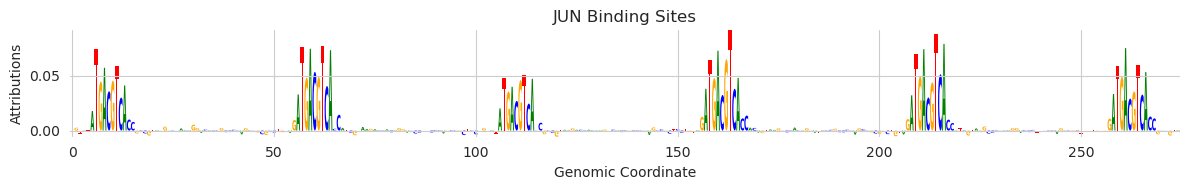

In [11]:
from tangermeme.plot import plot_logo

plt.figure(figsize=(12, 2))
plt.title("JUN Binding Sites")
plt.ylabel("Attributions")
plt.xlabel("Genomic Coordinate")
plot_logo(X_attr[0, :, 1057-105:1057+170])
plt.tight_layout()
plt.show()

Looks like the reason that this region had such strong binding of JUN, and the reason that there seemed to be several spikes in the predicted profiles, is that this is a region that has many AP-1 motifs in a row. There is interesting biology here that we will not go into, but you can see how with just a few lines of code of bpnet-lite + tangermeme we can go from a trained BPNet model, to finding a region that seems like there is more to explore, to getting an explanation as to <i>why</i> that region might be interesting to explore.

##### Variant Effect Prediction

A common goal for sequence-based prediction models is to predict the influence that variants have on phenotypes of interest. Usually, these are variants that have been identified as common (or rare!) in actual human populations, or among groups of people with particular diseases. In this setting, we usually make predictions for a region before and after incorporating the variants and aggregate the difference in predictions into a score that can be used to identify the variants driving molecular phenotypes from those that may only be happening by chance.

Once again, we can use tangermeme + bpnet-lite to quickly predict the influence of variants. Here, we will consider only substitutions, but one can also consider insertions or deletions. First, we will consider a substitution that involves knocking out a key nucleotide in the left-most AP-1 motif above. Making the variant effect predictions is just as simple as creating a sparse tensor of variants where the three columns correspond to example index, position index within the example, and which character index should be present at that position. If the chosen character is the same as the original character there will be no effect. For visual impact, we will focus on the softmaxed profile predictions.

In [12]:
from tangermeme.variant_effect import substitution_effect

variants = [
    [0, 960, 2],
]

before, after = substitution_effect(model, X[idx:idx+1], variants)
before = torch.softmax(before[0], dim=-1)
after = torch.softmax(after[0], dim=-1)

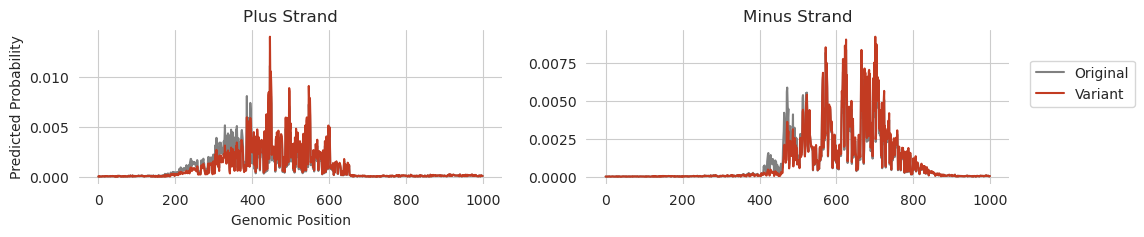

In [13]:
plt.figure(figsize=(12, 2))
plt.subplot(121)
plt.title("Plus Strand")
plt.plot(before[0, 0], c='0.5')
plt.plot(after[0, 0], c='#C23B22')
plt.xlabel("Genomic Position")
plt.ylabel("Predicted Probability")

seaborn.despine(bottom=True, left=True)


plt.subplot(122)
plt.title("Minus Strand")
plt.plot(before[0, 1], c='0.5', label="Original")
plt.plot(after[0, 1], c='#C23B22', label="Variant")
seaborn.despine(bottom=True, left=True)
plt.legend(loc=(1.05, 0.5))

plt.show()

Knocking out the left-most AP-1 motif seems to have the expected change in profile predictions, with the left-most predicted peak being knocked out. The rest of the peaks seem to be pretty similar to before. 

Sometimes, when considering a list of variants, you want to calculate the effect of each one individually and sometimes you want to calculate the influence of all variants incorporated at the same time. Here, you can do this by having multiple variants in your sparse tensor correspond to the same example. As a demonstration, we will now also consider a variant that knocks out binding in the second AP-1 site from the left.

In [14]:
from tangermeme.variant_effect import substitution_effect

variants = [
    [0, 960, 2],
    [0, 1009, 0]
]

before, after = substitution_effect(model, X[idx:idx+1], variants)
before = torch.softmax(before[0], dim=-1)
after = torch.softmax(after[0], dim=-1)

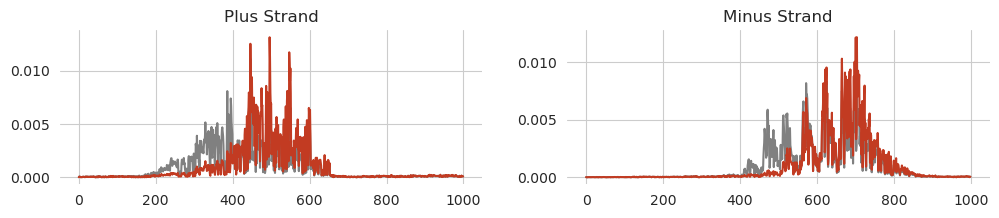

In [15]:
plt.figure(figsize=(12, 2))
plt.subplot(121)
plt.title("Plus Strand")
plt.plot(before[0, 0], c='0.5')
plt.plot(after[0, 0], c='#C23B22')
seaborn.despine(bottom=True, left=True)

plt.subplot(122)
plt.title("Minus Strand")
plt.plot(before[0, 1], c='0.5')
plt.plot(after[0, 1], c='#C23B22')
seaborn.despine(bottom=True, left=True)

plt.show()

Again, we get the expected result, with even more peaks from the left hand side being knocked out while the remainder of the predicted signal is less effected.

With BPNet models there are four different variant effect scores one can consider, based on differences in (1) log count prediction, (2) profile prediction, (3) log count attributions, and (4) profile attributions. Each one may be relevant in different ways, with profile predictions or attribution-based differences potentially being able to pick up on more subtle effects where some binding sites are eliminated but others remain, keeping general predicted binding high.

##### Design

As a final note, BPNet models can be used for design. Several design methods have been implemented in tangermeme but potentially the most widely used one right now is greedy substitution, where each potential mutation is considered at each round and the one that drives predictions towards the desired goal the most is kept. As a simple demonstration we will try to increase model predictions as much as possible using only ten iterations of this greedy approach. Here, we do not need to specify a specific target for the model to meet; rather, we want model predictions to go as high as possible.

In [16]:
from tangermeme.design import greedy_substitution

X = random_one_hot((1, 4, 2114), random_state=0)
X_hat = greedy_substitution(count_model, X, max_iter=10, verbose=True)

Iteration 0 -- Loss: -0.5266, Improvement: N/A, Idx: N/A, Time (s): 0s


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.04it/s]


Iteration 1 -- Loss: -0.7301, Improvement: 0.2036, Motif Idx: 0, Pos Idx: 1458, Time (s): 0.4441


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.63it/s]


Iteration 2 -- Loss: -0.8852, Improvement: 0.1551, Motif Idx: 2, Pos Idx: 472, Time (s): 0.4169


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.72it/s]


Iteration 3 -- Loss: -1.022, Improvement: 0.1368, Motif Idx: 0, Pos Idx: 1584, Time (s): 0.4139


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.72it/s]


Iteration 4 -- Loss: -1.136, Improvement: 0.1135, Motif Idx: 0, Pos Idx: 704, Time (s): 0.4132


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.75it/s]


Iteration 5 -- Loss: -1.361, Improvement: 0.2255, Motif Idx: 3, Pos Idx: 697, Time (s): 0.412


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.75it/s]


Iteration 6 -- Loss: -1.422, Improvement: 0.06125, Motif Idx: 3, Pos Idx: 1546, Time (s): 0.4114


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.74it/s]


Iteration 7 -- Loss: -1.48, Improvement: 0.0578, Motif Idx: 2, Pos Idx: 951, Time (s): 0.4117


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.66it/s]


Iteration 8 -- Loss: -1.533, Improvement: 0.05234, Motif Idx: 2, Pos Idx: 470, Time (s): 0.4152


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.76it/s]


Iteration 9 -- Loss: -1.581, Improvement: 0.04863, Motif Idx: 0, Pos Idx: 477, Time (s): 0.4109


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.76it/s]

Iteration 10 -- Loss: -1.63, Improvement: 0.04928, Motif Idx: 2, Pos Idx: 691, Time (s): 0.4106


Because the BPNet model is quite small, this design task finishes pretty quickly.

We can now look at model predictions and confirm that they have increased.

In [17]:
predict(count_model, X), predict(count_model, X_hat)

(tensor([[0.5266]]), tensor([[1.6305]]))

Now, we can use attribution methods to identify what sorts of motifs were added in to cause this increase in prediction.

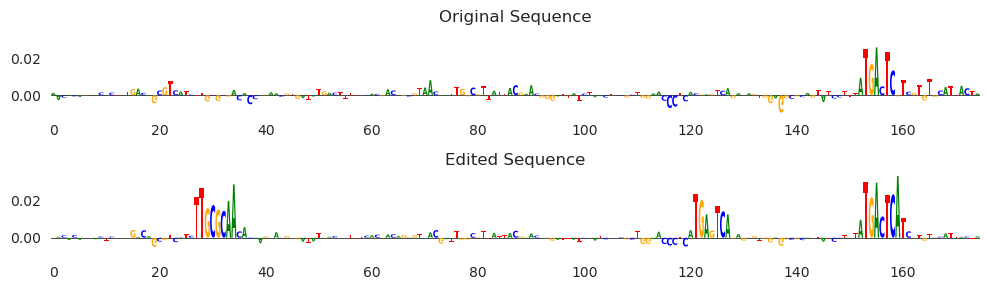

In [18]:
X_attr0 = deep_lift_shap(count_model, X)
X_attr1 = deep_lift_shap(count_model, X_hat)


s, e = 1425, 1600

plt.figure(figsize=(10, 3))
plt.subplot(211)
plt.title("Original Sequence")
plot_logo(X_attr0[0, :, s:e])
plt.ylim(-0.01, 0.035)
plt.grid(False)

plt.subplot(212)
plt.title("Edited Sequence")
plot_logo(X_attr1[0, :, s:e])
plt.ylim(-0.01, 0.035)
plt.grid(False)

plt.tight_layout()
plt.show()

Looks like we are mostly seeing AP-1 motifs, with one happening by chance on the right-hand side and increasing in affinity after some minor editing, and a second site being added around 120bp in. It looks like there is also a CEBP motif being added in between 20 and 40. Note that because these are attributions, it is not only the case that the motif sequence is there, but that the model is using this sequence to drive model predictions higher. This means that the model we are using seems to recognize CEBP motifs as well as the more classic AP-1 motifs when considering JUN binding.

#### Conclusions

In this introduction, we described what a BPNet model was, showed how one can use bpnet-lite to load and use these models, and highlighted some of the common operations that one may wish to do with a BPNet model. An important note is that this introduction is not comprehensive: it is meant only to show off a few of the features and get you started with these models. Please see the rest of the documentation for more thorough descriptions of the other operations that one can do with them.